# <p style="text-align: center;"> <b> Data Modeling </b> </p>


---

# Table of Contents

---

# 1. Problem Statement <a class="anchor" id="1"></a>

- Bài toán: Dự đoán số điểm của một bộ manga dựa trên các thông tin về bộ manga đó.

- Mô tả: 

- What are the purposes/benefits of solving this problem?

# 2. Data Preparation <a class="anchor" id="2"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast # for literal_eval

In [2]:
manga_df = pd.read_csv('../data/processed_comic.csv')
manga_df.head(3)

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Volumes,Chapters,Status,Genres,Author,Recommended,Mixed Feelings,Not Recommended,Release date,Completed date
0,Berserk,9.47,331288,1,1,665300,122841,4,28,Publishing,"['Action', 'Adventure', 'Award Winning', 'Dram...","['Miura Kentarou', 'Studio Gaga']",233,15,10,1989-08-25,2023-12-11
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,9.30,156368,2,26,256146,42864,24,96,Finished,"['Action', 'Adventure', 'Mystery', 'Supernatur...",['Araki Hirohiko'],120,7,1,2004-01-19,2011-04-19
2,Vagabond,9.24,136403,3,15,364891,40158,37,327,On Hiatus,"['Action', 'Adventure', 'Award Winning']","['Inoue Takehiko', 'Yoshikawa Eiji']",88,8,1,1998-09-03,2015-05-21


## 2.1 Feature Engineering<a class="anchor" id="2.1"></a>

### Feature Selection

1. We will select meaningful features that are suitable for the problem and drop unnecessary features.

    - The `Ranked` of manga series is determined based on `Score` by arranging the manga series in descending order of `Score`. Therefore, when predicting the `Score` of a manga, we cannot use `Ranked` as a feature, so we will drop this feature.
    
    - Two features, `Title` and `Author`, have a large number of unique values and do not provide meaningful insights for analyzing or predicting the score of a manga series. Therefore, we will drop these two features.

    - `Status` is a feature that indicates what status a manga is in (Publishing, Finished, ...). This feature has no meaning in predicting the `Score` of a manga, so we will drop this feature as well.


In [3]:
new_df = manga_df.drop(columns=['Title', 'Author','Ranked', 'Status'])

2. Use the correlation matrix to consider the correlation of features with `Score` and drop features with low correlation (correlation magnitude < 0.2)

But first, we will convert the numerical features to right data type.

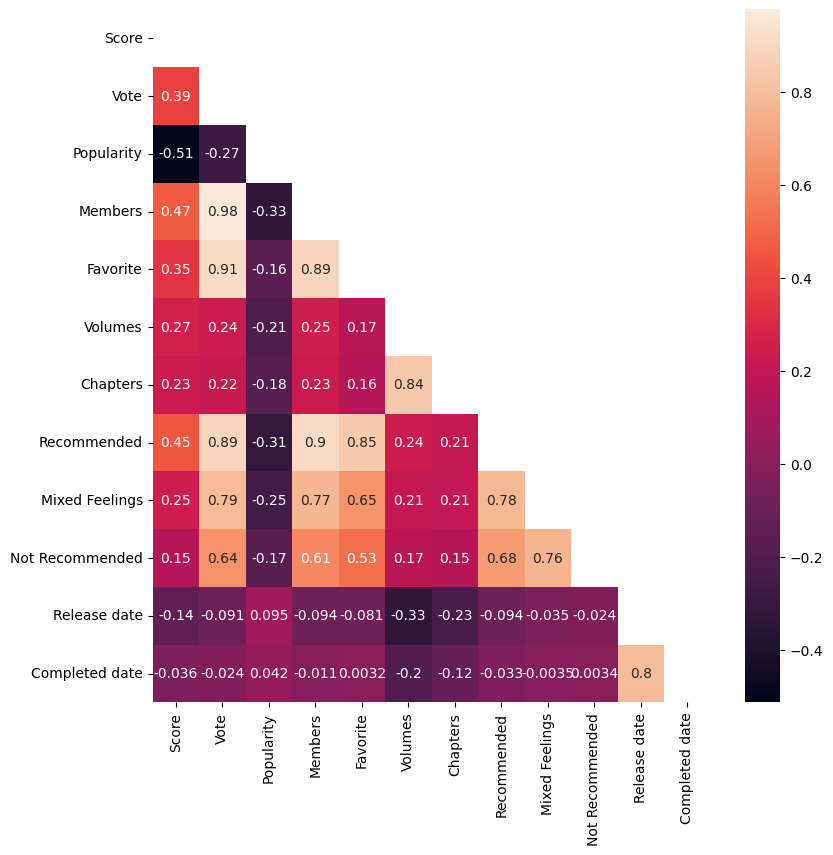

In [7]:
new_df[['Release date', 'Completed date']] = new_df[['Release date', 'Completed date']].apply(pd.to_datetime)

corr = new_df[['Score', 'Vote', 'Popularity', 'Members', 'Favorite','Volumes','Chapters','Recommended','Mixed Feelings','Not Recommended','Release date','Completed date']].corr()

fig, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, ax=ax, mask=mask)
plt.show()

`Status`, `Not Recommended`, `Released date` and `Completed date` have low correlation with `Score` and will be dropped.

In [9]:
new_df = new_df.drop(columns=['Release date', 'Completed date','Not Recommended'])
new_df.head(3)

,Score,Vote,Popularity,Members,Favorite,Volumes,Chapters,Genres,Recommended,Mixed Feelings
0,9.47,331288,1,665300,122841,4,28,"['Action', 'Adventure', 'Award Winning', 'Dram...",233,15
1,9.30,156368,26,256146,42864,24,96,"['Action', 'Adventure', 'Mystery', 'Supernatur...",120,7
2,9.24,136403,15,364891,40158,37,327,"['Action', 'Adventure', 'Award Winning']",88,8


### Convert categorical features to numerical features

The `Genres` feature represents a multi-label category, so we need to convert it to a list type first and then use multi-label binarizer to convert it to a numerical feature.

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert 'Genres' into list of strings
new_df['Genres'] = new_df['Genres'].apply(ast.literal_eval)
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(new_df['Genres']), columns=mlb.classes_, index=new_df.index)
new_df = pd.concat([new_df, genres_encoded], axis=1).drop(columns=['Genres'])
new_df.head(3)

,Score,Vote,Popularity,Members,Favorite,Volumes,Chapters,Recommended,Mixed Feelings,Action,...,Girls Love,Gourmet,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,9.47,331288,1,665300,122841,4,28,233,15,1,...,0,0,1,0,0,0,0,0,1,0
1,9.30,156368,26,256146,42864,24,96,120,7,1,...,0,0,0,1,0,0,0,0,1,0
2,9.24,136403,15,364891,40158,37,327,88,8,1,...,0,0,0,0,0,0,0,0,0,0


In [53]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score
from skopt import BayesSearchCV


features = ['Vote',  'Popularity', 'Members', 'Favorite', 'Volumes', 'Chapters',
            'Recommended', 'Mixed Feelings'] + list(mlb.classes_)
target = 'Score'


## 2.3 Split data <a class="anchor" id="2.3"></a>

In [12]:
# Chia dữ liệu thành tập train, validation, và test
train_data, test_data = train_test_split(new_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Chia features và target
X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

In [55]:
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(),
    'Random Forest': RandomForestRegressor()
}

In [80]:
n_folds = 5
val_errors = np.zeros((len(models), n_folds, 10))
train_errors = np.zeros((len(models), n_folds, 10))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
historys = []
for i, (name, model) in enumerate(models.items()):
    for j, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)

        # Calculate train and validation errors
        train_sizes, train_scores, val_scores = learning_curve(model, X_train_fold, y_train_fold, train_sizes=np.linspace(0.1, 1.0, 10), cv=kfold)

        # Store errors for plotting
        val_errors[i,j,:] = val_scores[:,j]
        train_errors[i,j,:] = train_scores[:,j]
        
        print(f'{name} - Fold {j+1}: {val_errors[i,j]}')
    

Linear Regression - Fold 1: [0.3925948  0.43803962 0.45791525 0.47521789 0.48015747 0.48835389
 0.49316902 0.49615135 0.49645463 0.48702411]
Linear Regression - Fold 2: [0.41407651 0.50107165 0.51653011 0.52905943 0.53041079 0.53847258
 0.53869398 0.53444155 0.53868418 0.5313622 ]
Linear Regression - Fold 3: [0.33779848 0.38368323 0.42010935 0.43291142 0.44029833 0.43452802
 0.43202717 0.42933643 0.43138162 0.43885739]
Linear Regression - Fold 4: [0.47398986 0.47331958 0.47637367 0.49331463 0.49929514 0.50112713
 0.5050264  0.50467633 0.50714797 0.50745763]
Linear Regression - Fold 5: [-0.81481736  0.47905116  0.4801606   0.48369572  0.48655581  0.48518384
  0.48949572  0.48996438  0.49169277  0.49227966]
XGBoost - Fold 1: [0.51882245 0.55294904 0.58521042 0.61390576 0.60252941 0.60401901
 0.63344457 0.62819432 0.6112526  0.63663414]
XGBoost - Fold 2: [0.56647611 0.59650789 0.62422056 0.62470225 0.62410965 0.64992738
 0.65798454 0.68307132 0.68350456 0.69177209]
XGBoost - Fold 3: [0.51

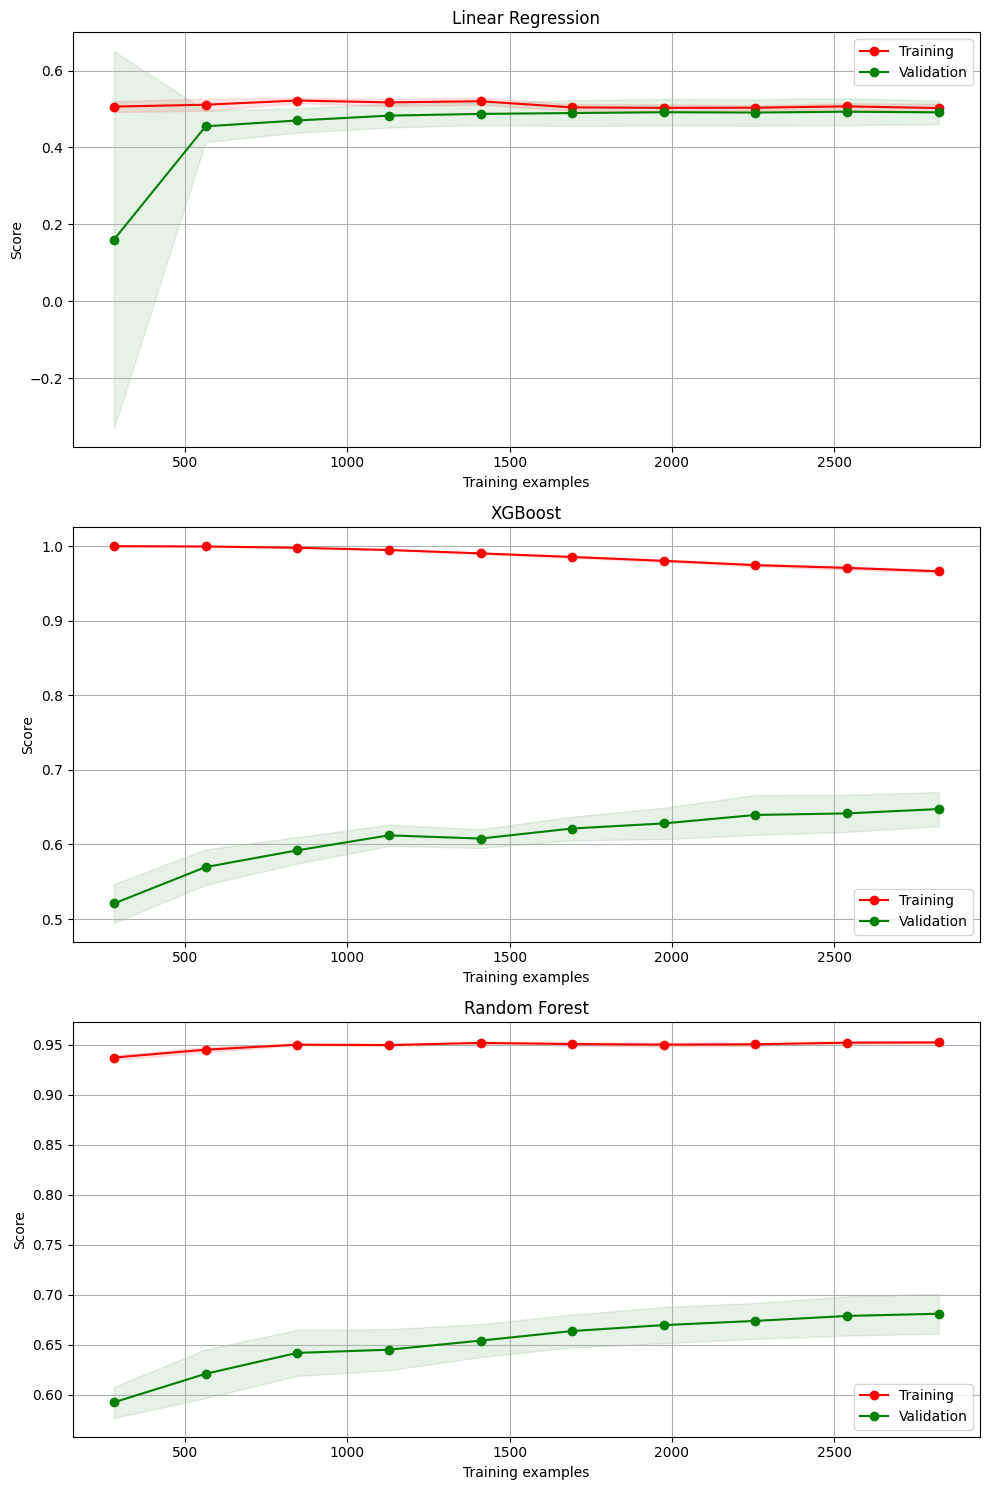

In [81]:
fig, axes = plt.subplots(len(models), 1, figsize=(10, 15))

for i, (name, model) in enumerate(models.items()):
    mean_train_errors = np.mean(train_errors[i], axis=0)
    std_train_errors = np.std(train_errors[i], axis=0)
    mean_val_errors = np.mean(val_errors[i], axis=0)
    std_val_errors = np.std(val_errors[i], axis=0)
    
    axes[i].plot(train_sizes, mean_train_errors, 'o-', color='r', label='Training')
    axes[i].plot(train_sizes, mean_val_errors, 'o-', color='g', label='Validation')
    axes[i].fill_between(train_sizes, mean_train_errors - std_train_errors, mean_train_errors + std_train_errors, alpha=0.1, color='r')
    axes[i].fill_between(train_sizes, mean_val_errors - std_val_errors, mean_val_errors + std_val_errors, alpha=0.1, color='g')
    axes[i].set_title(name)
    axes[i].set_xlabel('Training examples')
    axes[i].set_ylabel('Score')
    axes[i].grid(True)
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()

In [22]:
params_rf = {
    'n_estimators': (10, 100),
    'max_depth': (1, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

params_xgb = {
    'n_estimators': (10, 100),
    'max_depth': (1, 10),
    'learning_rate': (1e-3, 1e-1, 'log-uniform'),
    'gamma': (1e-3, 1e-1, 'log-uniform'),
    'min_child_weight': (1, 10),
    'subsample': (0.1, 1.0, 'uniform'),
    'colsample_bytree': (0.1, 1.0, 'uniform')
}


opt = BayesSearchCV(
    RandomForestRegressor(),
    params_rf,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42
)
np.int = int
opt.fit(X_train, y_train)
print(opt.best_params_)
print(opt.best_score_)
print(opt.score(X_test, y_test))

opt = BayesSearchCV(
    XGBRegressor(),
    params_xgb,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42
)

opt.fit(X_train, y_train)
print(opt.best_params_)
print(opt.best_score_)
print(opt.score(X_test, y_test))


c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


OrderedDict([('max_depth', 10), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 100)])
0.672679414081464
0.6762792258370807
OrderedDict([('colsample_bytree', 0.9558206697949769), ('gamma', 0.1), ('learning_rate', 0.09156844375490504), ('max_depth', 5), ('min_child_weight', 10), ('n_estimators', 56), ('subsample', 1.0)])
0.6767526441545885
0.6683701194475178


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np
data = new_df.copy()
target_column = 'Score'
# Chia dữ liệu thành features và target
X = data.drop(target_column, axis=1).values
y = data[target_column].values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Chia thành tập train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Chuyển dữ liệu thành Tensor
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Xây dựng mô hình
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1)
    def forward(self, x):
        x = self.fc1(x)

        return x

# Hàm huấn luyện mô hình
def train_model(model, train_loader, val_loader, num_epochs=200, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels)

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss.item():.3f}')

# Hàm tính score
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            true_labels.extend(labels.numpy())

    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    return mse, r2


# Tạo và huấn luyện mô hình
input_size = X_train.shape[1]
model = RegressionModel(input_size)
train_model(model, train_loader, val_loader)

# Đánh giá trên tập train
train_mse, train_r2 = evaluate_model(model, train_loader)
print(f'Train Mean Squared Error: {train_mse:.3f}, Train R^2 Score: {train_r2:.3f}')

# Đánh giá trên tập validation
val_mse, val_r2 = evaluate_model(model, val_loader)
print(f'Validation Mean Squared Error: {val_mse:.3f}, Validation R^2 Score: {val_r2:.3f}')

# Đánh giá trên tập test
test_mse, test_r2 = evaluate_model(model, test_loader)
print(f'Test Mean Squared Error: {test_mse:.3f}, Test R^2 Score: {test_r2:.3f}')


Epoch 1/200, Validation Loss: 547.920
Epoch 2/200, Validation Loss: 536.377
Epoch 3/200, Validation Loss: 525.169
Epoch 4/200, Validation Loss: 513.987
Epoch 5/200, Validation Loss: 503.144
Epoch 6/200, Validation Loss: 492.515
Epoch 7/200, Validation Loss: 481.935
Epoch 8/200, Validation Loss: 471.658
Epoch 9/200, Validation Loss: 461.402
Epoch 10/200, Validation Loss: 451.460
Epoch 11/200, Validation Loss: 441.603
Epoch 12/200, Validation Loss: 431.965
Epoch 13/200, Validation Loss: 422.396
Epoch 14/200, Validation Loss: 413.106
Epoch 15/200, Validation Loss: 403.843
Epoch 16/200, Validation Loss: 394.762
Epoch 17/200, Validation Loss: 385.805
Epoch 18/200, Validation Loss: 376.981
Epoch 19/200, Validation Loss: 368.316
Epoch 20/200, Validation Loss: 359.790
Epoch 21/200, Validation Loss: 351.375
Epoch 22/200, Validation Loss: 343.086
Epoch 23/200, Validation Loss: 334.966
Epoch 24/200, Validation Loss: 326.946
Epoch 25/200, Validation Loss: 319.085
Epoch 26/200, Validation Loss: 311

In [28]:
manga_df= pd.read_csv('../data/processed_comic.csv')
test_manga_df = manga_df.iloc[:,1:9]
test_manga_df.drop(columns=['Ranked'], inplace=True)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

3675 1226 1226
Epoch 1/200 - Train Loss: 50.67312543145542, Validation Loss: 50.32869338989258
Epoch 2/200 - Train Loss: 49.76477754527125, Validation Loss: 49.47079086303711
Epoch 3/200 - Train Loss: 48.94879650247508, Validation Loss: 48.64834976196289
Epoch 4/200 - Train Loss: 48.136920008166086, Validation Loss: 47.8383903503418
Epoch 5/200 - Train Loss: 47.34675512642696, Validation Loss: 47.04429244995117
Epoch 6/200 - Train Loss: 46.53913728122053, Validation Loss: 46.26407241821289
Epoch 7/200 - Train Loss: 45.76993672601108, Validation Loss: 45.49485397338867
Epoch 8/200 - Train Loss: 45.011081564015356, Validation Loss: 44.736690521240234
Epoch 9/200 - Train Loss: 44.25199403433964, Validation Loss: 43.98773956298828
Epoch 10/200 - Train Loss: 43.49739028667582, Validation Loss: 43.248775482177734
Epoch 11/200 - Train Loss: 42.76705557724525, Validation Loss: 42.5190315246582
Epoch 12/200 - Train Loss: 42.06994569712672, Validation Loss: 41.7977409362793
Epoch 13/200 - Train 

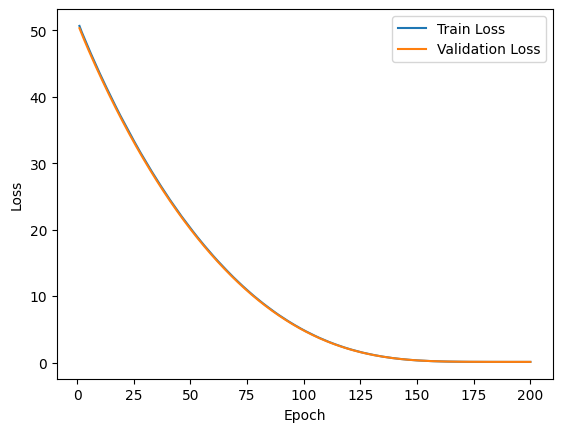

Mean Squared Error on Test Set: 0.10347705771870745, 0.3787231024870662


,Score
0,7.501661
1,7.096597
2,7.668390
3,7.370841
4,7.461866
...,...
1221,7.205900
1222,7.368014
1223,7.590829
1224,7.330178


In [29]:
X_train, X_test, y_train, y_test = train_test_split(test_manga_df.drop('Score', axis=1), test_manga_df['Score'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(len(X_train), len(X_test), len(X_val))
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors and create DataLoader
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define your linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize model, loss function, optimizer
model = LinearRegressionModel(input_size=X_train.shape[1])
criterion = nn.MSELoss()

# Choose your optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
train_losses = []
val_losses = []
best_model = None
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_loss}, Validation Loss: {val_loss.item()}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
# Plot the training and validation losses over epochs
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.load_state_dict(best_model)
# Test the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_mse = mean_squared_error(y_test, test_outputs.numpy())
    test_r2 = r2_score(y_test, test_outputs.numpy())
print(f'Mean Squared Error on Test Set: {test_mse}, {test_r2}')
# predict
predict = model(X_test_tensor)
predict = predict.detach().numpy()
predict = pd.DataFrame(predict)
predict.columns = ['Score']
predict